In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix 
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
 
df1 = pd.read_csv('https://raw.githubusercontent.com/AFAgarap/ecommerce-reviews-analysis/master/Womens%20Clothing%20E-Commerce%20Reviews.csv')
df = df1[['Review Text','Rating','Class Name','Age']]
#df1.info()
#df1.describe()
df.head()

,Review Text,Rating,Class Name,Age
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34
2,I had such high hopes for this dress and reall...,3,Dresses,60
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50
4,This shirt is very flattering to all due to th...,5,Blouses,47


In [4]:
# fill NA values by space
df['Review Text'] = df['Review Text'].fillna('')

# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array 
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
df['Word Counts'] = df['Review Text'].apply(wordcounts)
df.head()

,Review Text,Rating,Class Name,Age,Word Counts
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ..."
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':..."
2,I had such high hopes for this dress and reall...,3,Dresses,60,"{'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch..."
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'..."
4,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1..."


####Demonstrating the Densities of Class Names, Some Selected Words and All Words in the Reviews By Using WordCloud

In this section, I demonstrated the word densities which can be very informative. First, I selected some words which show the customer sentiments like love, hate, fantastic or regret. Second, since we do not know the product names, I decided to check the product class names. By doing this, we may at least learn the most prefered classes. Further, I thought that looking at the densities of all words in the reviews might be interesting. Lastly, I used the WordCloud module and printed the first five lines of the tables which shows the word counts for the selected words and the class names.

It can be observed from the below figures and tables that positive words as love, great, super were used more. When we look at the classes, customers mostly prefered dress, knits and blouses. We may also see that dress and love are in the freequently used words within all reviews.

Selected Words
love     8951
great    6117
super    1726
happy     705
glad      614
dtype: int64

Class Names
Dresses     6319
Knits       4843
Blouses     3097
Sweaters    1428
Pants       1388
Name: Class Name, dtype: int64


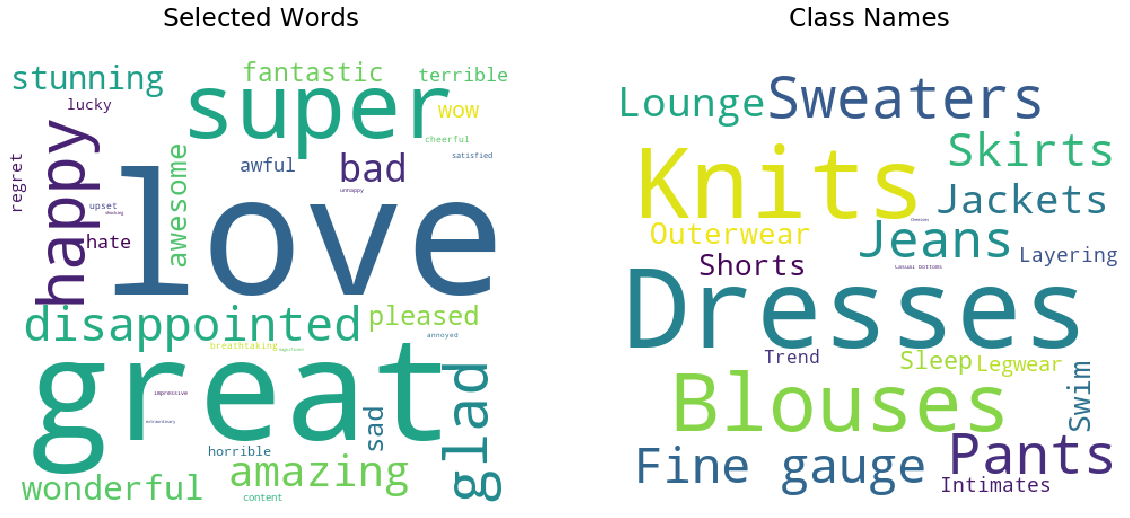

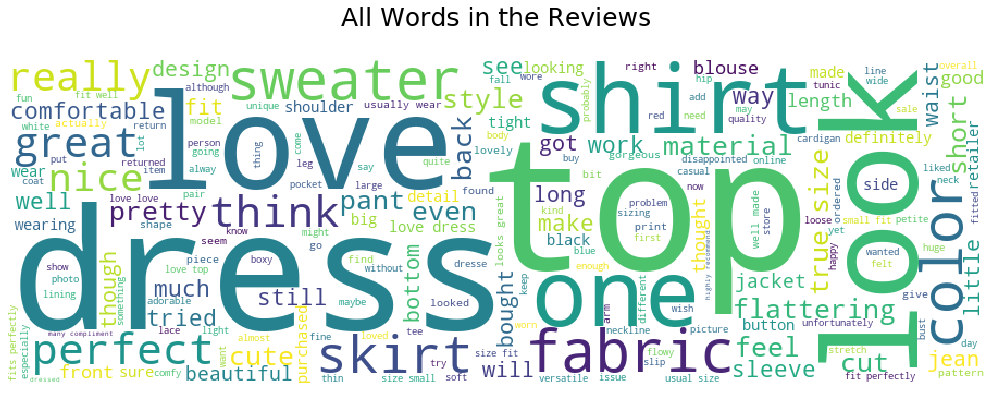

In [5]:
selectedwords = ['awesome','great','fantastic','extraordinary','amazing','super',
                 'magnificent','stunning','impressive','wonderful','breathtaking',
                 'love','content','pleased','happy','glad','satisfied','lucky',
                 'shocking','cheerful','wow','sad','unhappy','horrible','regret',
                 'bad','terrible','annoyed','disappointed','upset','awful','hate']

def selectedcount(dic,word):
    if word in dic:
        return dic[word]
    else:
        return 0
    
dfwc = df.copy()  
for word in selectedwords:
    dfwc[word] = dfwc['Word Counts'].apply(selectedcount,args=(word,))
    
word_sum = dfwc[selectedwords].sum()
print('Selected Words')
print(word_sum.sort_values(ascending=False).iloc[:5])

print('\nClass Names')
print(df['Class Name'].fillna("Empty").value_counts().iloc[:5])

fig, ax = plt.subplots(1,2,figsize=(20,10))
wc0 = WordCloud(background_color='white',
                      width=450,
                      height=400 ).generate_from_frequencies(word_sum)

cn = df['Class Name'].fillna(" ").value_counts()
wc1 = WordCloud(background_color='white',
                      width=450,
                      height=400 
                     ).generate_from_frequencies(cn)

ax[0].imshow(wc0)
ax[0].set_title('Selected Words\n',size=25)
ax[0].axis('off')

ax[1].imshow(wc1)
ax[1].set_title('Class Names\n',size=25)
ax[1].axis('off')

rt = df['Review Text']
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))
plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=25)
plt.axis('off')
plt.show()

##
Build a Sentiment Analyser

Since we do not have a column which shows the sentiment as positive or negative in the dataset, I defined a new sentiment column. To do this, I assumed the reviews which has 4 or higher rating as positive (True in the new dataframe) and 2 or lower rating as negative (False in the new dataframe). Also, I did not include the lines that has neutral ratings which are equal to 3.




In [7]:
# Rating of 4 or higher -> positive, while the ones with 
# Rating of 2 or lower -> negative 
# Rating of 3 -> neutral
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'] >=4
df.head()

,Review Text,Rating,Class Name,Age,Word Counts,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ...",True
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':...",True
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'...",True
4,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1...",True
5,"I love tracy reese dresses, but this one is no...",2,Dresses,49,"{'0p': 1, 'alterations': 1, 'am': 1, 'and': 4,...",False


First, I splitted the data as training and test. Afterwards, I fitted the models one by one. Since, some of them take too much time, I think running each of them in different cells is a better choice.



In [8]:
train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)
X_train = vectorizer.fit_transform(train_data['Review Text'])
y_train = train_data['Sentiment']
X_test = vectorizer.transform(test_data['Review Text'])
y_test = test_data['Sentiment']

Logistic Regression , Naive Bayes, SVM, Neural Net

In [10]:
start=dt.datetime.now()
lr = LogisticRegression()
lr.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))


start=dt.datetime.now()
nb = MultinomialNB()
nb.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

start=dt.datetime.now()
svm = SVC()
svm.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))


start=dt.datetime.now()
nn = MLPClassifier()
nn.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))


Elapsed time:  0:00:00.453760
Elapsed time:  0:00:00.004985
Elapsed time:  0:00:37.232989
Elapsed time:  0:05:13.507303


Evaluating Models

Adding Results to the Dataframe

At first, I added the prediction results to my training data. However, if you want to observe the prediction probabilies, you might use the commented out code.

In [11]:
# define a dataframe for the predictions
df2 = train_data.copy()
df2['Logistic Regression'] = lr.predict(X_train)
df2['Naive Bayes'] = nb.predict(X_train)
df2['SVM'] = svm.predict(X_train)
df2['Neural Network'] = nn.predict(X_train)
df2.head()

,Review Text,Rating,Class Name,Age,Word Counts,Sentiment,Logistic Regression,Naive Bayes,SVM,Neural Network
19218,I love this dress's gentle blue lace. the silh...,5,Dresses,35,"{'and': 1, 'as': 1, 'blue': 1, 'chest': 1, 'dr...",True,True,True,True,True
3530,Beautiful choice...beautiful fit for my daught...,5,Knits,51,"{'beautiful': 2, 'body': 1, 'choice': 1, 'daug...",True,True,True,True,True
15663,"If you are shaped anything like me, you will h...",4,Dresses,25,"{'am': 1, 'and': 2, 'anything': 1, 'are': 1, '...",True,True,True,True,True
21310,This top is so cute and of spectacular quality...,5,Blouses,33,"{'10': 1, '34c': 1, 'all': 1, 'almost': 1, 'an...",True,True,True,True,True
15154,First saw this poncho on a petite blog and aft...,5,Sweaters,56,"{'after': 1, 'and': 5, 'below': 1, 'blog': 1, ...",True,True,True,True,True


ROC Curves and AUC

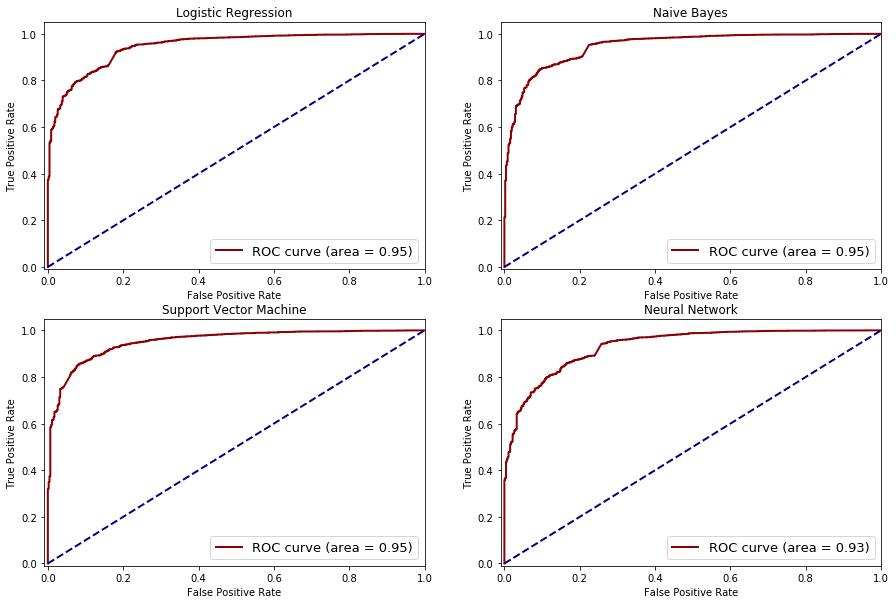

In [13]:
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test.values,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test.values,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

pred_nn = nn.predict_proba(X_test)[:,1]
fpr_nn,tpr_nn,_ = roc_curve(y_test.values,pred_nn)
roc_auc_nn = auc(fpr_nn,tpr_nn)

f, axes = plt.subplots(2, 2,figsize=(15,10))
axes[0,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Neural Network')
axes[1,1].legend(loc='lower right', fontsize=13);

Confusion Matrix

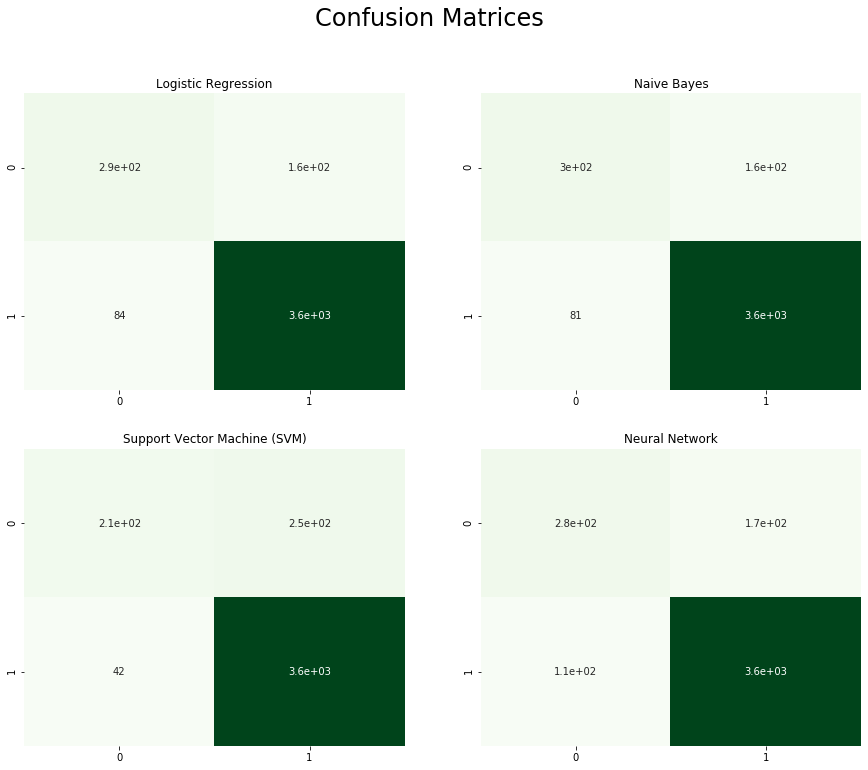

In [14]:
# preparation for the confusion matrix
lr_cm=confusion_matrix(y_test.values, lr.predict(X_test))
nb_cm=confusion_matrix(y_test.values, nb.predict(X_test))
svm_cm=confusion_matrix(y_test.values, svm.predict(X_test))
nn_cm=confusion_matrix(y_test.values, nn.predict(X_test))

plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,2,1)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,4)
plt.title("Neural Network")
sns.heatmap(nn_cm, annot = True, cmap="Greens",cbar=False);

Conclusion

When we look at the evaluating models section, Naive Bayes and Logistic Regression gives the best results. Thus, both of them are very effective at predicting sentiment. On the other hand, it seems that Naive Bayes takes less time and when we have a bigger dataset, this difference might increase and be an important advantage .